## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [ ]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


<h1>
    <p>Attention!™</p>
    <p>The main conclusions in human-readable format are at the end of the notebook.</p>
</h1>

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9283
Unique tokens in target (en) vocabulary: 6745


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'туры',
 'уроки',
 'красивых',
 'шэньчжэнь',
 'чеджу',
 'pestana',
 'фасад',
 'деревень',
 'стулом']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::100]

['<unk>',
 'conditioned',
 'b',
 'surrounded',
 'shop',
 'make',
 'harbour',
 'express',
 'exchange',
 'choose',
 'poolside',
 'inspired',
 'booked',
 'taste',
 'buildings',
 'yet',
 'washington',
 'locanda',
 'yekaterinburg',
 'blankets',
 'exercise',
 'gracia',
 'baiyun',
 'stables',
 'iii',
 'amadé',
 'lourdes',
 '59',
 'indira',
 'saturday',
 'brewery',
 'klong',
 'sales',
 'assisi',
 'everything',
 'maurice',
 'smolensk',
 'alpha',
 'cooler',
 'guadalajara',
 'marketplace',
 'recommend',
 'trang',
 'andorra',
 'cambodian',
 'eilat',
 'hart',
 'lorenzo',
 'olympia',
 'regensburg',
 'stairs',
 'westend',
 'amor',
 'bayswater',
 'capsule',
 'cornwall',
 'erfurt',
 'gibraltar',
 'hyères',
 'knysna',
 'm62',
 'monica',
 'omelets',
 'pondok',
 'safranbolu',
 'stazione',
 'tsim',
 'wilderness']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['il', 'salice', 'is', 'a', '10', '-', 'minute', 'drive', 'from', 'alghero', 'harbour', ',', 'and', 'alghero', 'fertilia', 'airport', 'can', 'be', 'reached', 'in', '20', 'minutes', 'by', 'car', '.'], 'src': ['отель', 'типа', '«', 'постель', 'и', 'завтрак', '»', 'il', 'salice', 'расположен', 'в', '10', 'минутах', 'езды', 'от', 'гавани', 'альгеро', ',', 'а', 'до', 'аэропорта', 'альгеро', 'фертилия', 'можно', 'добраться', 'на', 'машине', 'за', '20', 'минут', '.']}


Let's check the length distributions:

Length distribution in Train data


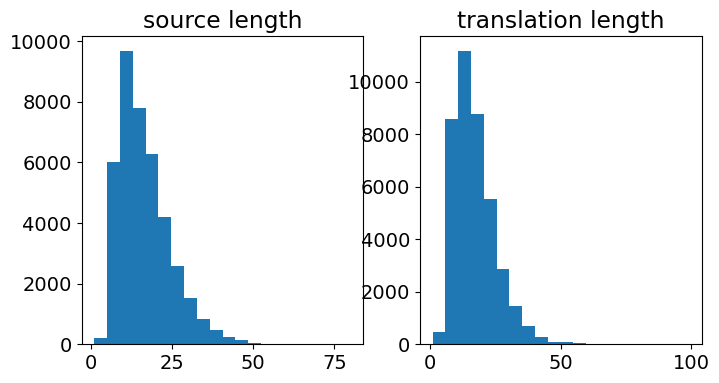

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


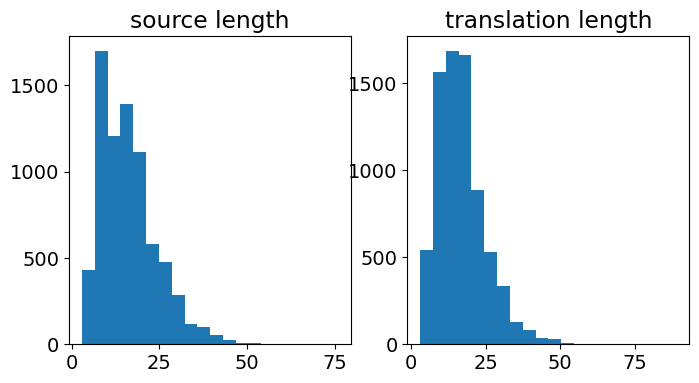

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 53x128 (GPU 0)]
torch.Size([53, 128]) torch.Size([47, 128])


<h1>
    Testing side
</h1>

In [ ]:
import utilities

In [ ]:
import basic_model

Encoder = basic_model.Encoder
Decoder = basic_model.Decoder
TestModel = basic_model.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.4, 0.4
ENC_HID_DIM, DEC_HID_DIM = 512, 512
N_LAYERS = 3

enc = Encoder(input_dim=INPUT_DIM,   emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, hid_dim=ENC_HID_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, hid_dim=DEC_HID_DIM)

model = TestModel(enc, dec, device).to(device)

In [ ]:
model.apply(utilities.init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9230, 256)
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6741, 256)
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.4)
    (out): Linear(in_features=512, out_features=6741, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
)

In [ ]:

print(f'The model has {utilities.count_parameters(model):,} trainable parameters')

The model has 19,105,621 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

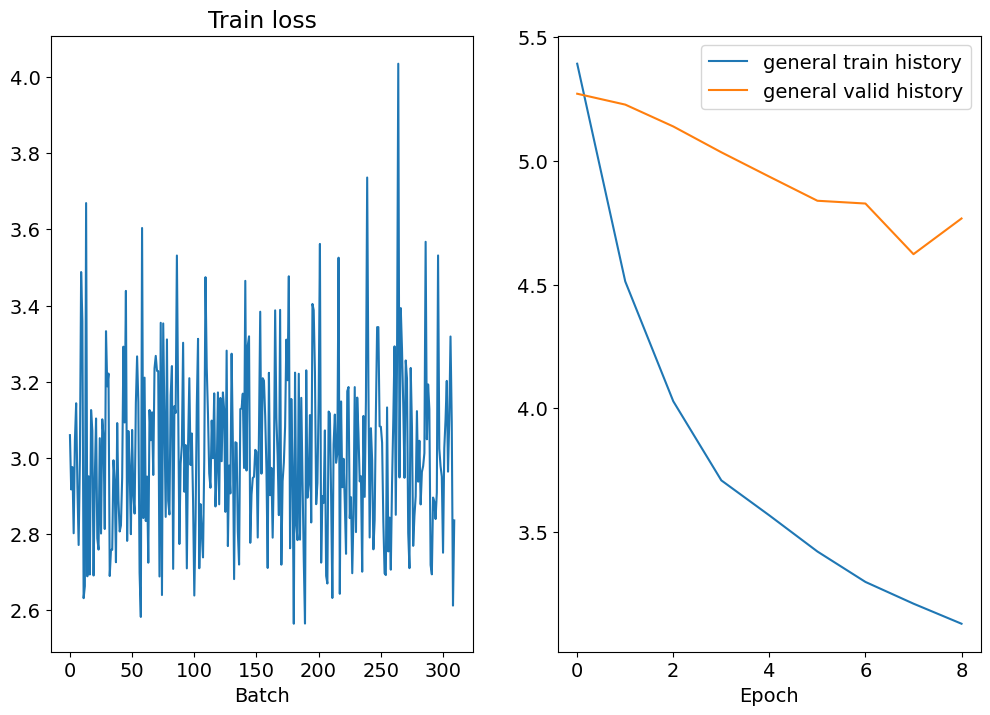

Epoch: 10 | Time: 2m 0s
	Train Loss: 3.014 | Train PPL:  20.359
	 Val. Loss: 4.683 |  Val. PPL: 108.065


In [ ]:
for epoch in range(0*N_EPOCHS, 1*N_EPOCHS):

    start_time = time.time()

    train_loss = utilities.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utilities.evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = utilities.epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'basic-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    utilities.generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: a 24 - hour front desk .

Original: the kitchen is fitted with a dishwasher .
Generated: the kitchen comes with a dishwasher and a .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)

        original_text.extend([utilities.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utilities.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:03, 15.69it/s]


12.318312821727032

<h1>
    BPE improvements
</h1>

In [ ]:
from IPython.utils import io
import sentencepiece as spm
import pandas as pd

In [ ]:
data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)
data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)
data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)

with io.capture_output() as captured:
    spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'ru', vocab_size = 3000, model_type = 'bpe');
    spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'eng', vocab_size = 2000, model_type = 'bpe');

In [ ]:
en_load = spm.SentencePieceProcessor()
en_load.Load('eng.model');

ru_load = spm.SentencePieceProcessor()
ru_load.Load('ru.model');

In [ ]:
def bpe_tokenizer_en(x):
  return en_load.encode(x, out_type = str)

def bpe_tokenizer_ru(x):
  return ru_load.encode(x, out_type = str)

In [ ]:
SRC = Field(tokenize=bpe_tokenizer_ru,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=bpe_tokenizer_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 132x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 113x128 (GPU 0)]
torch.Size([113, 128]) torch.Size([132, 128])


In [ ]:
import utilities

In [ ]:
import basic_model

Encoder = basic_model.Encoder
Decoder = basic_model.Decoder
TestModel = basic_model.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.4, 0.4
ENC_HID_DIM, DEC_HID_DIM = 512, 512
N_LAYERS = 3

enc = Encoder(input_dim=INPUT_DIM,   emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, hid_dim=ENC_HID_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, hid_dim=DEC_HID_DIM)

model = TestModel(enc, dec, device).to(device)
model.apply(utilities.init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2729, 256)
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1811, 256)
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.4)
    (out): Linear(in_features=512, out_features=1811, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
)

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

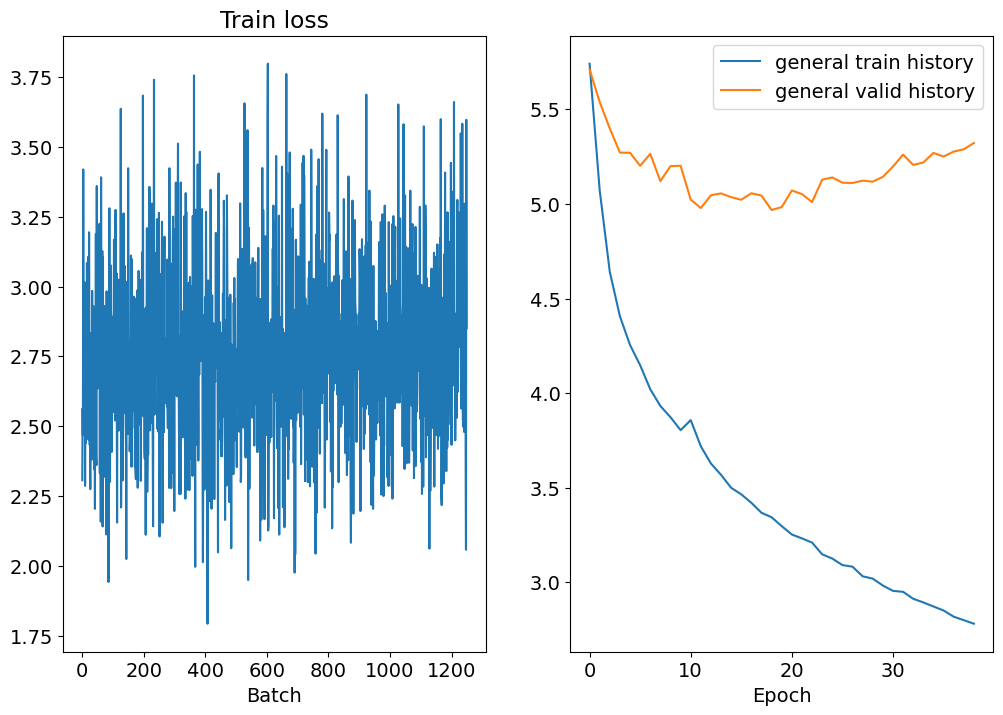

Epoch: 40 | Time: 3m 23s
	Train Loss: 2.759 | Train PPL:  15.786
	 Val. Loss: 5.308 |  Val. PPL: 201.964


In [ ]:
for epoch in range(2*N_EPOCHS, 4*N_EPOCHS):

    start_time = time.time()

    train_loss = utilities.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utilities.evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = utilities.epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bpe-only-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    utilities.generate_translation(src, trg, model, TRG.vocab)

Original: ▁there ▁is ▁a ▁24- hour ▁front ▁desk ▁at ▁the ▁property .
Generated: ▁24- hour ▁reception ▁desk .

Original: ▁free ▁private ▁parking ▁is ▁available ▁on ▁site .
Generated: ▁free ▁parking ▁is ▁available ▁on ▁site .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)

        original_text.extend([utilities.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utilities.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

235it [00:04, 49.69it/s]


14.818712151808796

<h1>
    Multihead Attention
</h1>

In [ ]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer


Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize, init_token = '<sos>', eos_token = '<eos>', lower = True)
TRG = Field(tokenize=tokenize, init_token = '<sos>', eos_token = '<eos>', lower = True)

dataset = torchtext.data.TabularDataset(path=path_do_data,format='tsv',fields=[('trg', TRG), ('src', SRC)])
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 37x64 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 36x64 (GPU 0)]
torch.Size([36, 64]) torch.Size([37, 64])


In [ ]:
import utilities

In [ ]:
import attention_model

Encoder = attention_model.Encoder
Decoder = attention_model.Decoder
TestModel = attention_model.AttentionModel

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.5, 0.5
ENC_HID_DIM, DEC_HID_DIM = 512, 512
N_LAYERS = 2

enc = Encoder(input_dim=INPUT_DIM,   emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, hid_dim=ENC_HID_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, hid_dim=DEC_HID_DIM)

model = TestModel(enc, dec, device).to(device)
model.apply(utilities.init_weights)

AttentionModel(
  (encoder): Encoder(
    (layers): ModuleDict(
      (embedding): Embedding(9218, 256)
      (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): Decoder(
    (layers): ModuleDict(
      (embedding): Embedding(6725, 256)
      (rnn): LSTM(768, 512, num_layers=2, dropout=0.5)
      (linear): Linear(in_features=512, out_features=6725, bias=True)
      (attention): Multi_head_attention_trs(
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (final_attn): Attention(
          (attn): Linear(in_features=1024, out_features=512, bias=True)
        )
      )
    )
  )
)

In [ ]:

print(f'The model has {utilities.count_parameters(model):,} trainable parameters')
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

The model has 17,513,285 trainable parameters


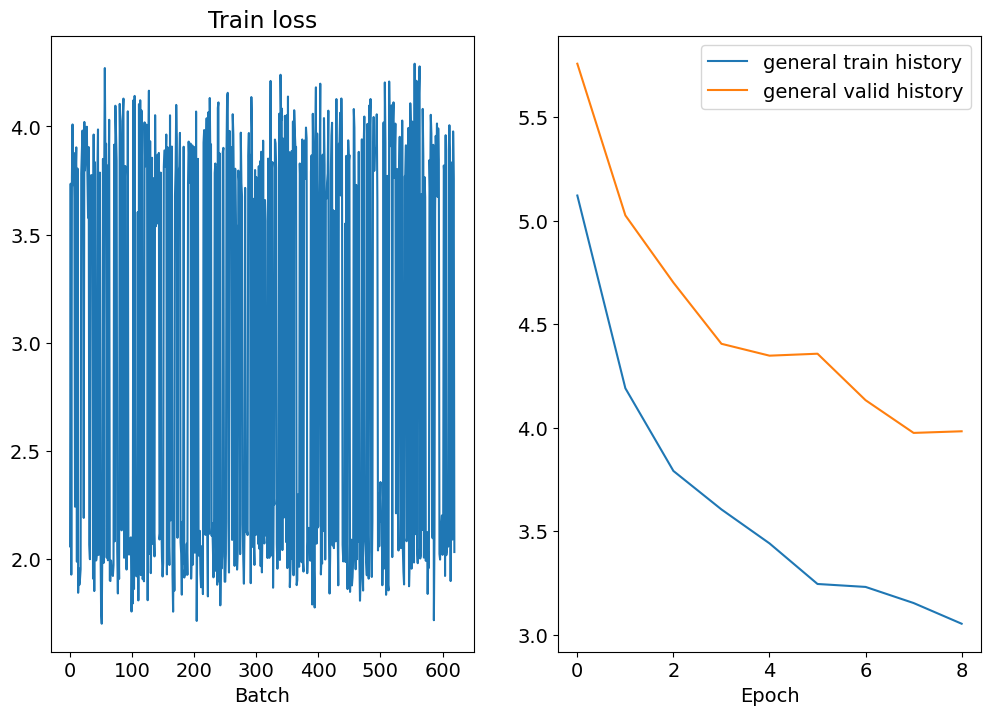

Epoch: 10 | Time: 7m 20s
	Train Loss: 2.946 | Train PPL:  19.021
	 Val. Loss: 3.990 |  Val. PPL:  54.080


In [ ]:
for epoch in range(0*N_EPOCHS, 1*N_EPOCHS):

    start_time = time.time()

    train_loss = utilities.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utilities.evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = utilities.epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
batch = next(iter(test_iterator))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    utilities.generate_translation(src, trg, model, TRG.vocab)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)

        original_text.extend([utilities.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utilities.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

118it [00:14,  7.98it/s]


16.430805254970114

<h1>
    Positional encoding
</h1>

In [ ]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer


Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize, init_token = '<sos>', eos_token = '<eos>', lower = True)
TRG = Field(tokenize=tokenize, init_token = '<sos>', eos_token = '<eos>', lower = True)

dataset = torchtext.data.TabularDataset(path=path_do_data,format='tsv',fields=[('trg', TRG), ('src', SRC)])
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 42x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 41x128 (GPU 0)]
torch.Size([41, 128]) torch.Size([42, 128])


In [ ]:
import utilities

In [ ]:
import pe_model

Encoder = pe_model.Encoder
Decoder = pe_model.Decoder
TestModel = pe_model.PEmodel

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.5, 0.5
ENC_HID_DIM, DEC_HID_DIM = 512, 512
N_LAYERS = 2

enc = Encoder(input_dim=INPUT_DIM,   emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, hid_dim=ENC_HID_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, hid_dim=DEC_HID_DIM)

model = TestModel(enc, dec, device).to(device)
model.apply(utilities.init_weights)

PEmodel(
  (encoder): Encoder(
    (embedding): Embedding(9249, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (positional_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6699, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (positional_encoding): PositionalEncoding()
    (out): Linear(in_features=512, out_features=6699, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:

print(f'The model has {utilities.count_parameters(model):,} trainable parameters')
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

The model has 14,875,691 trainable parameters


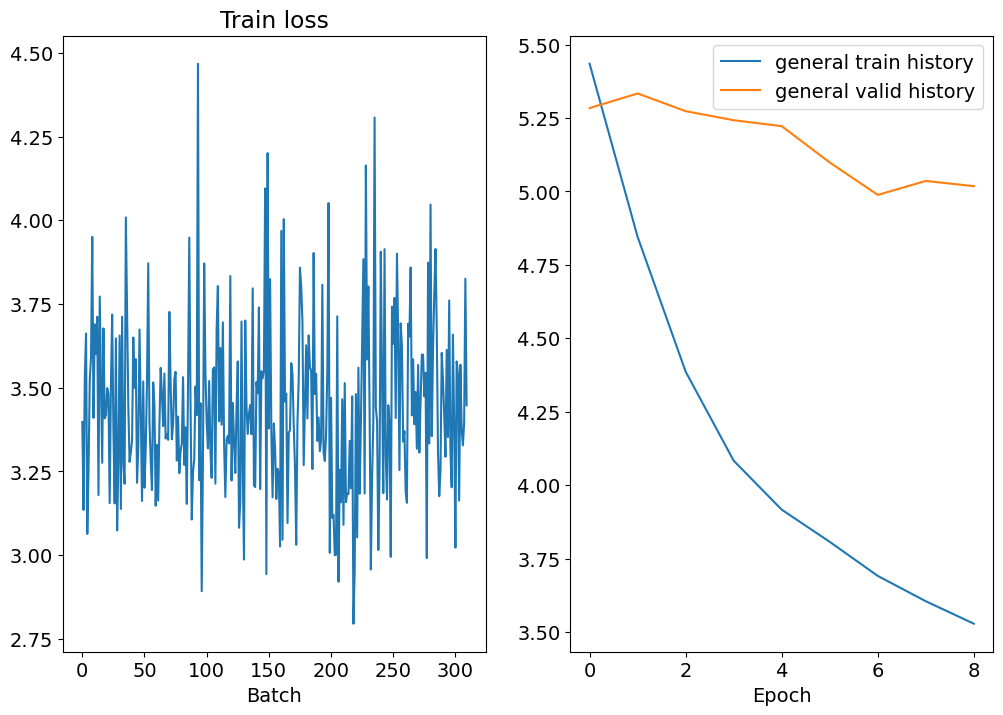

Epoch: 10 | Time: 1m 45s
	Train Loss: 3.440 | Train PPL:  31.194
	 Val. Loss: 4.910 |  Val. PPL: 135.679


In [ ]:
for epoch in range(0*N_EPOCHS, 1*N_EPOCHS):

    start_time = time.time()

    train_loss = utilities.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utilities.evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = utilities.epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
batch = next(iter(test_iterator))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    utilities.generate_translation(src, trg, model, TRG.vocab)

Original: free private parking is available .
Generated: private parking is available on site .

Original: front desk is open 24 hours .
Generated: the can also be arranged .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)

        original_text.extend([utilities.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utilities.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:03, 17.39it/s]


13.741602351727769

<h1>
    All improvements in one model!
</h1>

In [1]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator

import spacy


import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from IPython.utils import io
import sentencepiece as spm
import pandas as pd


Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [2]:
data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)
data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)
data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)

with io.capture_output() as captured:
    spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'ru', vocab_size = 3000, model_type = 'bpe');
    spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'eng', vocab_size = 2000, model_type = 'bpe');

In [3]:
en_load = spm.SentencePieceProcessor()
en_load.Load('eng.model');

ru_load = spm.SentencePieceProcessor()
ru_load.Load('ru.model');

In [4]:
def bpe_tokenizer_en(x):
  return en_load.encode(x, out_type = str)

def bpe_tokenizer_ru(x):
  return ru_load.encode(x, out_type = str)

In [5]:
SRC = Field(tokenize=bpe_tokenizer_ru,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=bpe_tokenizer_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 16]
	[.trg]:[torch.cuda.LongTensor of size 47x16 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 43x16 (GPU 0)]
torch.Size([43, 16]) torch.Size([47, 16])


In [9]:
import utilities

In [10]:
import megazord

Encoder = megazord.Encoder
Decoder = megazord.Decoder
TestModel = megazord.Megazord

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.5, 0.5
ENC_HID_DIM, DEC_HID_DIM = 512, 512
N_LAYERS = 2

enc = Encoder(input_dim=INPUT_DIM,   emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, hid_dim=ENC_HID_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, hid_dim=DEC_HID_DIM)

model = TestModel(enc, dec, device).to(device)
model.apply(utilities.init_weights)

Megazord(
  (encoder): Encoder(
    (layers): ModuleDict(
      (embedding): Embedding(2737, 256)
      (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
      (pos_encod): PositionalEncoding()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): Decoder(
    (layers): ModuleDict(
      (embedding): Embedding(1815, 256)
      (pos_encod): PositionalEncoding()
      (rnn): LSTM(768, 512, num_layers=2, dropout=0.5)
      (linear): Linear(in_features=512, out_features=1815, bias=True)
      (attention): Multi_head_attention_trs(
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (final_attn): Attention(
          (attn): Linear(in_features=1024, out_features=512, bias=True)
        )
      )
    )
  )
)

In [11]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [12]:
train_history = []
valid_history = []

N_EPOCHS = 9
CLIP = 1

best_valid_loss = float('inf')

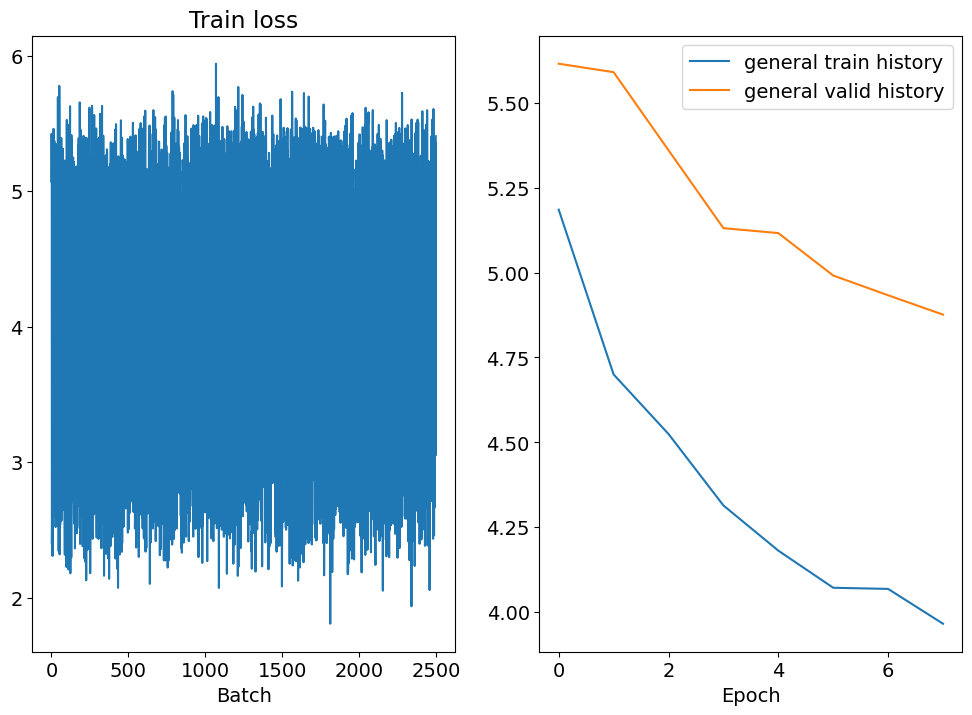

Epoch: 09 | Time: 13m 5s
	Train Loss: 3.937 | Train PPL:  51.289
	 Val. Loss: 4.886 |  Val. PPL: 132.480


In [13]:
for epoch in range(0*N_EPOCHS, 1*N_EPOCHS):

    start_time = time.time()

    train_loss = utilities.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utilities.evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = utilities.epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bpe-only-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [14]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    utilities.generate_translation(src, trg, model, TRG.vocab)

In [18]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)

        original_text.extend([utilities.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utilities.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

469it [00:25, 18.45it/s]


28.116422181765103

<h1>
    Transformer(added here just for fun)
</h1>

<h5>
I really now have no idea why it is so bad
</h5>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 32]
	[.trg]:[torch.cuda.LongTensor of size 54x32 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 61x32 (GPU 0)]
torch.Size([61, 32]) torch.Size([54, 32])


In [ ]:
import utilities

In [ ]:
import transformer

Encoder = transformer.Encoder
Decoder = transformer.Decoder
TestModel = transformer.Transformer

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.4, 0.4
ENC_HID_DIM, DEC_HID_DIM = 256, 256
N_LAYERS = 1
SRC_PAD_IDX, TRG_PAD_IDX, TRG_SOS_IDX = SRC.vocab.stoi['<pad>'], TRG.vocab.stoi['<pad>'], TRG.vocab.stoi['<sos>']

enc = Encoder(input_dim=INPUT_DIM,   emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, hid_dim=ENC_HID_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, hid_dim=DEC_HID_DIM)

model = TestModel(enc, dec, device, INPUT_DIM, OUTPUT_DIM, ENC_EMB_DIM, DEC_EMB_DIM, SRC_PAD_IDX, TRG_PAD_IDX, TRG_SOS_IDX).to(device)

1 1 2


In [ ]:
model.apply(utilities.init_weights)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(9230, 256)
    (positional_encoding): PositionalEncoding()
    (dropout_1): Dropout(p=0.4, inplace=False)
    (dropout_2): Dropout(p=0.4, inplace=False)
    (nodes): ModuleList(
      (0): ModuleDict(
        (SelfAttention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (LayerNorm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (CrossAttention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (LayerNorm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (Linear_1): Linear(in_features=256, out_features=256, bias=True)
        (Activation): ReLU(inplace=True)
        (Dropout): Dropout(p=0.4, inplace=False)
        (Linear_2): Linear(in_features=256, out_features=256, bias=True)
        (LayerNorm_3): LayerNorm((25

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
for epoch in range(0*N_EPOCHS, 1*N_EPOCHS):

    start_time = time.time()

    train_loss = utilities.train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = utilities.evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = utilities.epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    utilities.generate_translation(src, trg, model, TRG.vocab)

Original: ▁co é ▁hall d is ▁apartment ▁is ▁a ▁col lection ▁of ▁in de p end ent ▁proper t ies ▁all ▁located ▁in ▁the ▁in ▁the ▁co é ▁district , ▁n am ed ▁by ▁the ▁ar ch ite ct ▁wh o ▁design ed ▁it , ▁d ates ▁b ack ▁to ▁the ▁ ‘ 2 0 es ▁and ▁w as ▁bu ilt ▁for ▁e m b ass ies . ▁ch ar ac ter ist ic ▁of ▁this ▁ne igh bour h ood ▁are ▁the ▁di ff ere nt ▁sty les ▁s ym b ol iz ing ▁the ▁most ▁famous ▁c ities ▁in ▁ital y , ▁such ▁as ▁f lo rence ▁and ▁v en ice .
Generated: ▁h es ide ▁in ▁the ▁ren ov ated ▁building ▁of ▁the ▁s m in , , , , ▁the , ▁the ▁a b us , , ▁the ▁a ▁self - catering ▁accommodation ▁in ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁of ▁the ▁the ▁of ▁the ▁of ▁the ▁the ▁of ▁the ▁of ▁the ▁the ▁of ▁the ▁of ▁the ▁the ▁of ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the ▁of ▁the ▁the .

Original: ▁st ā r is ▁is ▁a ▁d et ached ▁holiday ▁home

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)

        original_text.extend([utilities.get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([utilities.get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

corpus_bleu([[text] for text in original_text], generated_text) * 100

<h1>
    Results
</h1>

| Method   |      BLEU score      |  Cool |
|----------|:-------------:|------:|
| Basic Model |  12.318 | +- |
| BPE |    14.819   |   + |
| Multihead Attent | 16.431 |    + |
| Positional encoding | 13.742 |    + |
| BPE+Multihead Attention+Positional Encoding | 28.116 |    +   |
| Transformer | 11.2 | -- |

In this table you can see 8 hours(only right running) of trainging in free google colab